<a href="https://colab.research.google.com/github/Elman295/Deep-LSTM-for-pothole-detection/blob/main/pothole_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install datasets

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from datasets import load_dataset

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch import nn

#`Data`

In [3]:
data = load_dataset("keremberke/pothole-segmentation",name = "full")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
data

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 80
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 5
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 5
    })
})

In [5]:
def extract_bbox(id, type_data = "train", detail = False):
  d = data[type_data][id]["objects"]["bbox"][0]

  if detail == False:
    return d
  else:
    return d[0],d[1],d[2],d[3]

[224.0, 282.0, 186.70799255371094, 105.77799987792969]


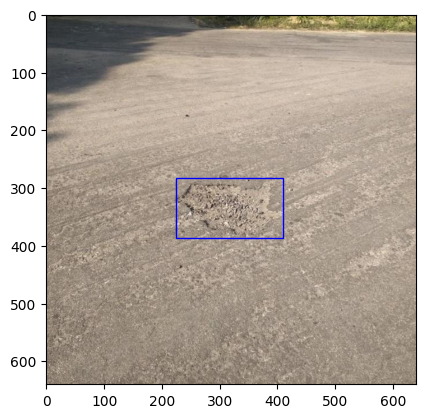

In [6]:

plt.imshow(data["train"][0]["image"])
print(extract_bbox(0))


plt.gca().add_patch(Rectangle((224,282),186,105,linewidth=1,edgecolor='b',facecolor='none'))
plt.show()

In [7]:
tfms = transforms.Compose([
    transforms.Resize(size = (100,100)),
    transforms.ToTensor()
])

In [82]:
class DS(Dataset):

  def __init__(self, data, data_subset = "train", tfms  = None):

    self.data = data
    self.datasubset = data_subset
    self.tfms = tfms

  def __len__(self):

    return len(self.data[self.datasubset])

  def __getitem__(self, idx):

    image = self.data[self.datasubset][idx]["image"]

    if self.tfms is not None:
      image = self.tfms(image)

    bbox = np.array(self.data[self.datasubset][idx]["objects"]["bbox"][0]) / 6.5

    return image, torch.tensor(bbox, dtype = torch.float32)



In [83]:
len(data["train"])

80

In [84]:
train_ds = DS(data, "train",tfms)

test_ds = DS(data, "test",tfms)

In [39]:
image, bbox = train_ds[10]

tensor([35.5385, 39.0769, 29.2580, 23.7403])


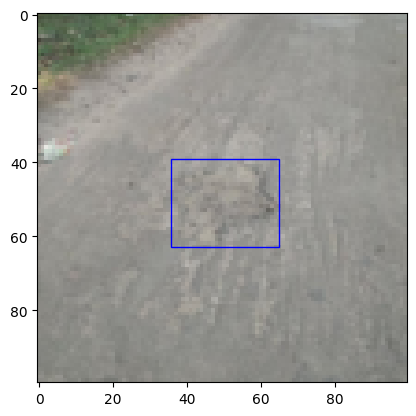

In [40]:
plt.imshow(image.permute(1,2,0))
print(bbox)
plt.gca().add_patch(Rectangle((bbox[0],bbox[1]),width=bbox[2],height=bbox[3],linewidth=1,edgecolor='b',facecolor='none'))
plt.show()

In [41]:
image.shape

torch.Size([3, 100, 100])

In [42]:
def patchify(image_batch, patch_size = 10):

  b,c,w,h = image_batch.shape

  image_batch = image_batch.reshape(b,c,w // patch_size,patch_size,h // patch_size, patch_size)
  image_batch = image_batch.permute(0,1,2,4,3,5)
  image_batch = image_batch.reshape(b,c, 100,patch_size, patch_size)
  image_batch = image_batch.permute(0,2,1,3,4)
  return image_batch


In [79]:
train_dl = DataLoader(dataset = train_ds, batch_size = 32, shuffle = True)
test_dl = DataLoader(dataset = test_ds, batch_size = 32, shuffle = True)

In [44]:
image, bbox = next(iter(train_dl))

In [45]:
bbox.shape

torch.Size([32, 4])

In [18]:
print(image.shape)

torch.Size([32, 3, 100, 100])


In [19]:
image_patchified = patchify(image)

In [20]:
print(image_patchified.shape)

torch.Size([32, 100, 3, 10, 10])


In [21]:
image_patchified[0].shape

torch.Size([100, 3, 10, 10])

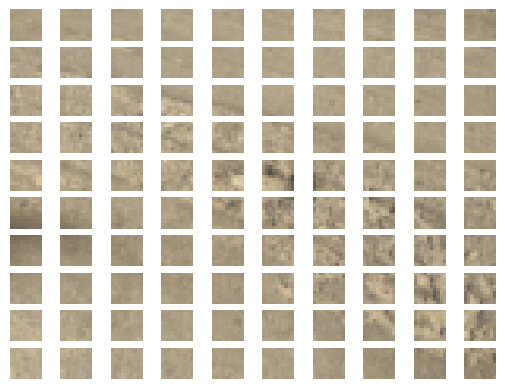

In [22]:
for i in range(100):
  plt.subplot(10,10,i+1)
  plt.imshow(image_patchified[0][i].permute(1,2,0))
  plt.axis("off")

plt.show()

In [23]:
class Deep_LSTM(nn.Module):

  def __init__(self):
    super(Deep_LSTM, self).__init__()

    self.lstm = nn.LSTM(3*10*10,3*10*10, batch_first=True)
    self.norm_1 = nn.LayerNorm(3*10*10)
    self.mlp = nn.Sequential(
        nn.Linear(3*10*10, 500),
        nn.GELU(),
        nn.Linear(500, 3*10*10)
    )

  def forward(self, x):

    # x = patchify(x)
    # x = x.reshape(-1,26*26,3*25*25)
    x_norm = self.norm_1(x)
    x_lstm,_ = self.lstm(x_norm)
    f = x_lstm + x_norm
    f_mlp = self.mlp(f)
    f_out = f_mlp + f

    return f_out


In [24]:
model = Deep_LSTM()
x = torch.rand(size = (32,100,3*10*10))
y = model(x)
print(y.shape)

torch.Size([32, 100, 300])


In [47]:
class Deep_LSTM_main(nn.Module):

  def __init__(self, num_layers = 5):
    super(Deep_LSTM_main, self).__init__()

    self.block = nn.Sequential(*[Deep_LSTM() for i in range(num_layers)])

    self.head = nn.Linear(300,4)

  def forward(self, x):


    x = patchify(x)
    x = x.reshape(-1,100,3*10*10)

    f = self.block(x)
    f = f[:,-1,:]
    f = self.head(f)
    return f

In [48]:
model_main = Deep_LSTM_main()
x = torch.rand(size = (32,3,100,100))
y = model_main(x)
print(y.shape)

torch.Size([32, 4])


In [49]:
opt = torch.optim.Adam(params = model_main.parameters(), lr = 1e-3)
loss_fn = nn.MSELoss()

In [52]:
def train(data, model, opt, loss_fn):

  model.train()

  size = len(data.dataset)

  for b,(x,y) in enumerate(data):

    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    opt.zero_grad()
    loss.backward()
    opt.step()

    if b % 100 == 0:
      print(f"[{b*len(x)} | {size}]  loss:{loss.item()}")


In [53]:
def test(data, model, loss_fn):

  model.eval()

  size = len(data.dataset)
  num_batch = len(data)
  test_loss, test_acc = 0,0

  with torch.no_grad():
    for x,y in data:
      y_pred = model(x)
      test_loss += loss_fn(y_pred, y).item()

    test_loss /= num_batch
    print(f"test loss : {test_loss}")



In [67]:
for e in range(20):
  print(f"epoch:{e+1}=-=-=-=-")
  train(train_dl, model_main, opt, loss_fn)
  # test(test_dl, model_main, loss_fn)

epoch:1=-=-=-=-
[0 | 50]  loss:225.90432739257812
epoch:2=-=-=-=-
[0 | 50]  loss:142.2895050048828
epoch:3=-=-=-=-
[0 | 50]  loss:127.8013687133789
epoch:4=-=-=-=-
[0 | 50]  loss:174.83872985839844
epoch:5=-=-=-=-
[0 | 50]  loss:120.08921813964844
epoch:6=-=-=-=-
[0 | 50]  loss:212.43687438964844
epoch:7=-=-=-=-
[0 | 50]  loss:221.46148681640625
epoch:8=-=-=-=-
[0 | 50]  loss:153.91563415527344
epoch:9=-=-=-=-
[0 | 50]  loss:89.88632202148438
epoch:10=-=-=-=-
[0 | 50]  loss:172.3880157470703
epoch:11=-=-=-=-
[0 | 50]  loss:154.6741485595703
epoch:12=-=-=-=-
[0 | 50]  loss:102.87533569335938
epoch:13=-=-=-=-
[0 | 50]  loss:135.43739318847656
epoch:14=-=-=-=-
[0 | 50]  loss:125.20928955078125
epoch:15=-=-=-=-
[0 | 50]  loss:155.95608520507812
epoch:16=-=-=-=-
[0 | 50]  loss:113.66072845458984
epoch:17=-=-=-=-
[0 | 50]  loss:108.39027404785156
epoch:18=-=-=-=-
[0 | 50]  loss:70.83580780029297
epoch:19=-=-=-=-
[0 | 50]  loss:61.7860221862793
epoch:20=-=-=-=-
[0 | 50]  loss:103.901535034179

torch.Size([32, 3, 100, 100])


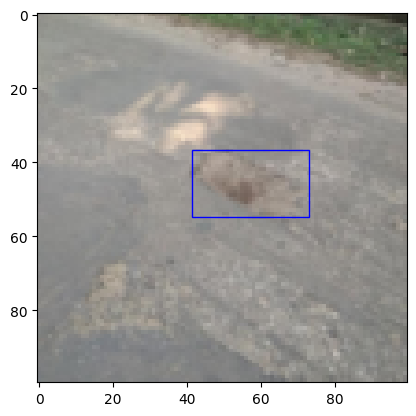

In [68]:
x,y = next(iter(train_dl))
print(x.shape)
y_pred = model_main(x)

plt.imshow(x[0].permute(1,2,0))
plt.gca().add_patch(Rectangle((y[0,0],y[0,1]),y[0,2],y[0,3],linewidth=1,edgecolor='b',facecolor='none'))
plt.show()

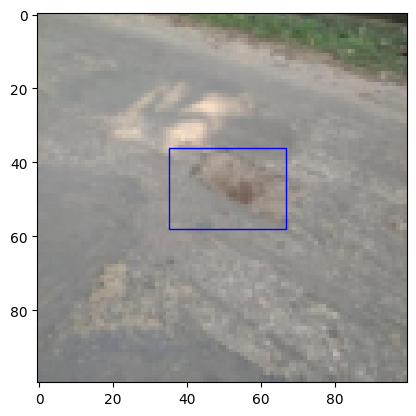

In [69]:
plt.imshow(x[0].permute(1,2,0))
plt.gca().add_patch(Rectangle((y_pred[0,0].detach().numpy(),y_pred[0,1].detach().numpy()),y_pred[0,2].detach().numpy(),y_pred[0,3].detach().numpy(),linewidth=1,edgecolor='b',facecolor='none'))
plt.show()

torch.Size([5, 3, 100, 100])


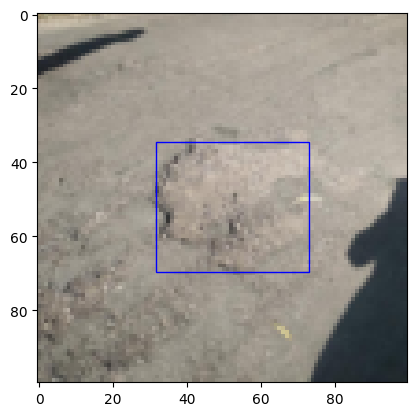

In [86]:
x,y = next(iter(test_dl))
print(x.shape)
y_pred = model_main(x)

plt.imshow(x[0].permute(1,2,0))
plt.gca().add_patch(Rectangle((y[0,0],y[0,1]),y[0,2],y[0,3],linewidth=1,edgecolor='b',facecolor='none'))
plt.show()

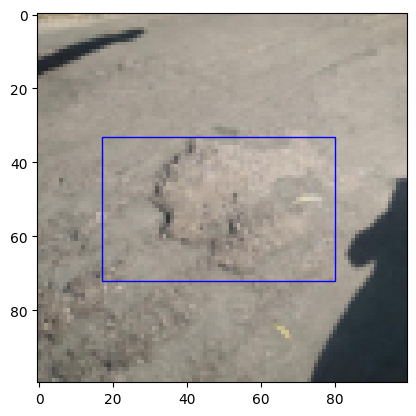

In [87]:
plt.imshow(x[0].permute(1,2,0))
plt.gca().add_patch(Rectangle((y_pred[0,0].detach().numpy(),y_pred[0,1].detach().numpy()),y_pred[0,2].detach().numpy(),y_pred[0,3].detach().numpy(),linewidth=1,edgecolor='b',facecolor='none'))
plt.show()